In [17]:
#!pip install py2neo

import os
import pandas as pd
import matplotlib.pyplot as plt
import py2neo
from py2neo import Graph,Node,Relationship

import IPython

print ('py2neo version', py2neo.__version__)
%matplotlib inline

py2neo version 2021.2.3


In [2]:
# Connect the repository to the DB
db_url = 'neo4j@bolt://neo4j@localhost:7687'
db_pass = 'tweets'

graph = Graph(db_url, password = db_pass)

In [4]:
#consulta de prueba

nodos_tweet="MATCH(t:Tweet) RETURN t.id, t.text, t.like_count ORDER BY t.like_count DESC LIMIT 25"

#evaluamos las consultas
tweets=graph.run(nodos_tweet).to_data_frame() 

tweets

,t.id,t.text,t.like_count
0,1518623997054918657,I hope that even my worst critics remain on Tw...,3322952
1,1376712834269159425,#StopAsianHate\n#StopAAPIHate https://t.co/mOm...,2550038
2,1368913515977744385,아직 날씨가 쌀쌀하니 따뜻하게 입고 다니세요 !\n#JIMIN https://t.c...,2306319
3,1261298966160797696,태태와 함께! #0613FM_0515 https://t.co/TY0T3lO3YV,2277194
4,1524082224886579202,Hi https://t.co/Hg2BvVJubZ,2042623
5,1523465632502906880,"If I die under mysterious circumstances, it’s ...",1940777
6,1524082723555786753,Bye https://t.co/Tf4jXphMnD,1882691
7,1528987173927522304,とりあえずあと4話。 https://t.co/OwoB4ljp1x,1490711
8,1527669475910242305,I love him https://t.co/ys7WlVDBxb,1398807
9,1521202951230046210,As I was saying … https://t.co/tsGz6fCWuW,1370842


In [5]:
# conteo de nodos
nro_nodos_user="MATCH(u:User) RETURN Count(u)"
nro_nodos_tweet="MATCH(t:Tweet) RETURN Count(t)"
nro_nodos_hashtag="MATCH(h:Hashtag) RETURN Count(h)"

#evaluamos las consultas
result_users=graph.evaluate(nro_nodos_user)
result_tweets=graph.evaluate(nro_nodos_tweet)
result_hashtags=graph.evaluate(nro_nodos_hashtag)

#imprimo resultados
print(f'En la BD hay {result_users} nodos User, {result_tweets} nodos Tweet y {result_hashtags} nodos Hashtag.')


En la BD hay 55863 nodos User, 405389 nodos Tweet y 12884 nodos Hashtag.


In [7]:
# detalle de users y tweets

consulta = (
    "match (u:User) -[:TWEETED]-> (t:Tweet {country: 'UY'}) "
    "return count(distinct(u)), count(t);"
)

result_cons=graph.run(consulta).to_data_frame() 

print(f'Tweets posteados desde Uruguay con geolocalización activada: {result_cons.iloc[0,1]}')
print(f'Tweets sin geolocalización (referenciados por tweets con geolocalización): {result_tweets - result_cons.iloc[0,1]}')
print(f'Usuarios que postearon al menos una vez desde Uruguay con geolocalización activada: {result_cons.iloc[0,0]}')
print(f'Resto de los usuarios: {result_users - result_cons.iloc[0,0]}')


Tweets posteados desde Uruguay con geolocalización activada: 276546
Tweets sin geolocalización (referenciados por tweets con geolocalización): 128843
Usuarios que postearon al menos una vez desde Uruguay con geolocalización activada: 9309
Resto de los usuarios: 46554


In [10]:
# conteo de relaciones

consulta_1 = (
    "MATCH ()-[r]->() "
    "RETURN count(r);"
)

result_cons_1=graph.evaluate(consulta_1)

print(f'Hay {result_cons} relaciones')

consulta_2 = (
    "match ()-[r]->() "
    "with type(r) as rel_type, count(r) as number "
    "return rel_type, number;"
)

result_cons_2=graph.run(consulta_2).to_data_frame() 
result_cons_2

Hay 1098388 relaciones


,rel_type,number
0,TWEETED,405389
1,REPLY,185220
2,MENTIONS,427789
3,TAG,41782
4,QUOTE,38208


In [12]:
# usuarios con más seguidores

consulta = (
    "match (u:User) -[r:TWEETED]-> (t:Tweet) "
    "with u, count(t) as tweets_in_uy_conversation, u.name as name, u.followers as followers "
    "return name, followers, tweets_in_uy_conversation "
    "order by followers desc "
    "limit 25;"
)

result_cons = graph.run(consulta).to_data_frame() 
result_cons

,name,followers,tweets_in_uy_conversation
0,Elon Musk,96333321,22
1,Lady Gaga,84737729,4
2,Ellen DeGeneres,77527323,4
3,Kim Kardashian,72589607,1
4,Bill Gates,59326794,1
5,CNN,58389658,2
6,NASA,57796162,1
7,The New York Times,53157945,3
8,LeBron James,51460079,3
9,방탄소년단,46161306,6


In [13]:
# hashtags más usados

consulta = (
    "match (t:Tweet) -[r:TAG]-> (h:Hashtag) "
    "with h, count(r) as hashtag_count "
    "return h.tag, hashtag_count "
    "order by hashtag_count desc "
    "limit 25;"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

,h.tag,hashtag_count
0,uruguay,623
1,lamascarauy,553
2,marchadelsilencio2022,528
3,peñarol,411
4,mayomesdelamemoria,390
5,todossomosfamiliares,276
6,bts,238
7,nacional,234
8,puntopenalenel10,231
9,renunciaheber,228


<BarContainer object of 31 artists>

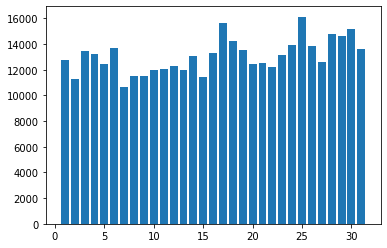

In [19]:
# tweet volume by day of the month

consulta = (
    "match (t:Tweet) "
    "with (datetime(t.created_at) - duration({hours: 3})).day as day, count(t) as total_tweets "
    "return day, total_tweets "
    "order by day asc;"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

plt.bar(x=result_cons.day, height=result_cons.total_tweets)

<BarContainer object of 24 artists>

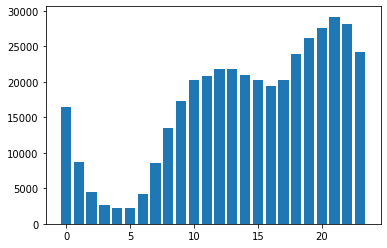

In [21]:
# tweet volume by hour of the day

consulta = (
    "match (t:Tweet) "
    "with (datetime(t.created_at) - duration({hours: 3})).hour as hour, count(t) as total_tweets "
    "return hour, total_tweets "
    "order by hour asc;"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

plt.bar(x=result_cons.hour, height=result_cons.total_tweets)

In [22]:
# tweet volume by department

consulta = (
    "match (t:Tweet {country: 'UY'}) "
    "with t.department as department, count(t) as total_tweets "
    "where total_tweets > 1000 "
    "return department, total_tweets "
    "order by total_tweets desc;"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

,department,total_tweets
0,Montevideo,169267
1,Canelones,29638
2,Maldonado,22716
3,Colonia,9406
4,Salto,5323
5,San José,4704
6,Soriano,4109
7,Paysandú,3739
8,Florida,3314
9,Cerro Largo,3237
